In [1]:
!ls

'=3.0.0'				  preprocess_data
 advanced-segmentation-structure	  pretrain_result
 bk-isut-dataset			  pretrain_weights
 crop_output				  __pycache__
 eval.ipynb				  result
 eval_pspnet.ipynb			  save_data_path
 fine_tune_segformer.py			  SegFormer
 get_pretrain_weight.py			  smooth_tiled_predictions.py
 global-land-cover-mapping-openearthmap   train_baseline.py
 inference.ipynb			  train_segformer.py
 infer_image				  train_upernet.py
 infer_light_weight_model.ipynb		  Upernet
 offline_distill_train.py		  weights


In [2]:
import os

In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing

2024-06-30 17:31:14.973907: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 17:31:14.992522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 17:31:14.992542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 17:31:14.992555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 17:31:14.996242: I tensorflow/core/platform/cpu_feature_g

Segmentation Models: using `tf.keras` framework.


In [6]:
img = cv2.imread("infer_image/original.tif", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = plt.imread("infer_image/mask.tif")

In [7]:
# Use this code to infer a smaller patch of a large image
width = 2560
height = 2560
# Calculate the coordinates for the top right quarter
start_row, start_col = height // 10 * 4, width // 10 * 4 
end_row, end_col = height // 10 * 6, width // 10 * 6

# Extract the top right quarter of the image
img = img[start_row:end_row, start_col:end_col]

# Extract the top right quarter of the mask
mask = mask[start_row:end_row, start_col:end_col]

In [8]:
# from Upernet.models import upernet_convnext_tiny


In [9]:
%cd "SegFormer"
from models import SegFormer_B0

/home/work2/Workspace/sonnh/do_an_test/SegFormer


In [10]:
checkpoint_path = "../weights/best_lightweight_model/cp.weights.h5"
model = SegFormer_B0(input_shape = (256,256,3), num_classes = 5)
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)
model.load_weights(checkpoint_path)

2024-06-30 17:31:15.966818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-30 17:31:15.966833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ngoc-Z790-D-DDR4
2024-06-30 17:31:15.966836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ngoc-Z790-D-DDR4
2024-06-30 17:31:15.966873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-06-30 17:31:15.966880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-06-30 17:31:15.966882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


In [11]:
# size of patches
patch_size = 256

# Number of classes 
n_classes = 5

In [12]:
large_img = Image.fromarray(img)
large_img = np.array(large_img)     
print(large_img.shape)

(512, 512, 3)


In [13]:
import time

In [14]:
# Start the timer
start_time = time.time()

# Predict patch by patch with no smooth blending
SIZE_X = (img.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
SIZE_Y = (img.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size

large_img = Image.fromarray(img)
large_img = large_img.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
large_img = np.array(large_img)
print(large_img.shape)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
patches_img = patches_img[:, :, 0, :, :, :]
print(patches_img.shape)

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        
        # Use MinMaxScaler instead of just dividing by 255.
        # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :, :]
        
        
        
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
print(patched_prediction.shape)  # Should be (number_of_patches, patch_height, patch_width)

# Reshape to 4D array
patched_prediction = patched_prediction.reshape((patches_img.shape[0], patches_img.shape[1], patch_size, patch_size))

# Unpatchify to get the large image
unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

# End the timer
end_time = time.time()

# Calculate and print the total time taken
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

(512, 512, 3)
(2, 2, 256, 256, 3)
1/1 [==============================] - 1s 1s/step


2024-06-30 17:31:18.024092: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7b2ddc00b280 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-30 17:31:18.024111: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-30 17:31:18.028747: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-30 17:31:18.028832: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1/1 [==============================] - 0s 97ms/step
(4, 256, 256)
Total time taken: 1.38 seconds


In [15]:
# Smooth blending
# predictions_smooth = predict_img_with_smooth_windowing(
#     img,
#     window_size=patch_size,
#     subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
#     nb_classes=n_classes,
#     pred_func=(
#         lambda img_batch_subdiv: model.predict((img_batch_subdiv))
#     )
# )


# final_prediction = np.argmax(predictions_smooth, axis=2)

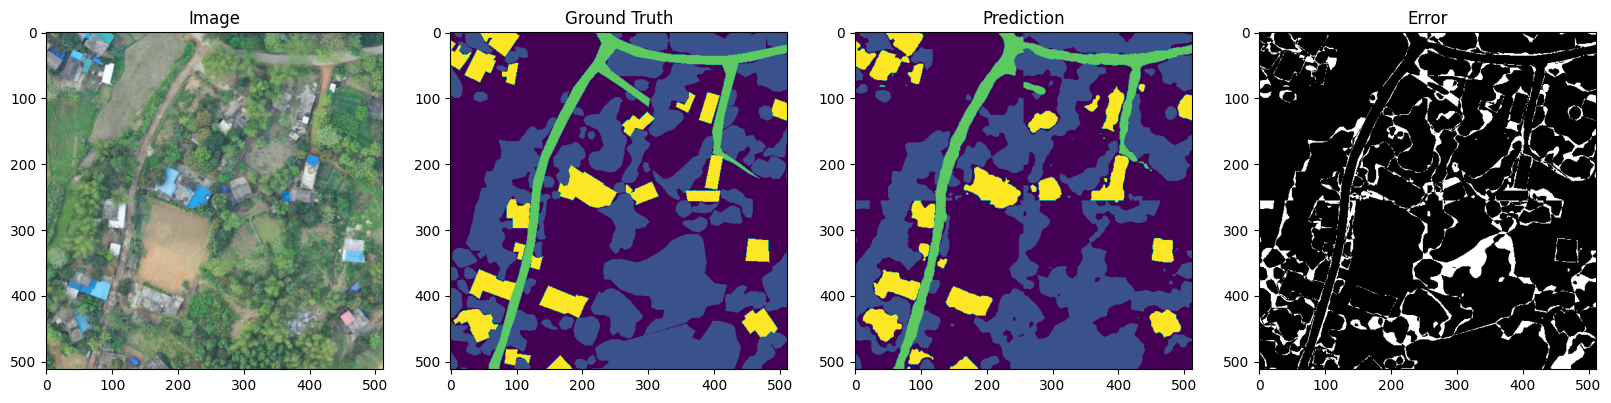

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.title('Image')
plt.imshow(img)
plt.subplot(142)
plt.title('Ground Truth')
plt.imshow(mask, vmin=0, vmax=4)
plt.subplot(143)
plt.title('Prediction')
plt.imshow(unpatched_prediction, vmin=0, vmax=4)
# plt.subplot(223)
# plt.title('Error with smooth prediction')
# error = (mask != final_prediction)
# error = error.astype('float32')
# plt.imshow(error, cmap='gray')

plt.subplot(144)
plt.title('Error')
error = (mask != unpatched_prediction)
error = error.astype('float32')
plt.imshow(error, cmap='gray')
plt.show()